## 

# Dependencies

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [3]:
raw_file=pd.read_csv("/home/sohanx1/Downloads/Telegram Desktop/selected/Fraud.csv")
raw_file.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## The below code shows that the given dataset is already clean 
 ### - No duplicate row 
 ### - No Null values in any column
 ### - All rows are of same size

In [4]:
raw_file.isnull().sum()
raw_file.shape
raw_file.duplicated().sum()
raw_file.count()

step              6362620
type              6362620
amount            6362620
nameOrig          6362620
oldbalanceOrg     6362620
newbalanceOrig    6362620
nameDest          6362620
oldbalanceDest    6362620
newbalanceDest    6362620
isFraud           6362620
isFlaggedFraud    6362620
dtype: int64

# **Class Imbalance** 
### - No of not Fraud are quite high compared to number of fraud .
### - NO of flagged Fraud is also very less compared to not flagged Fraud 

## Trying to use SMOTE ,ENSEMBLE LEARNING for this


# **Why Class Imbalance Matters**
### The Problem

### - In your dataset, fraud = only ~0.13% of transactions.

### - If you trained a model without addressing imbalance, it could simply predict “Not Fraud” for every transaction → it would achieve 99.9% accuracy but catch 0 frauds.

### - This is called the accuracy paradox in imbalanced datasets.




## **Business Risks if Ignored(imbalance class)**

### 1.Undetected fraud:
#### - Missing even 1% of frauds can mean millions in financial loss.For example: if 10,000 fraudulent transactions occur monthly, a naive model (biased to majority class) might catch almost none.

### 2.Customer trust loss:
#### - If customers see fraudulent debits not being stopped, they lose trust in the financial institution.

### 3.Regulatory penalties:
#### - Many regions (e.g., EU, US) require strong fraud monitoring. Missing fraud due to poor models can result in compliance fines.

### 4.Operational inefficiency:
#### - If imbalance is not handled, the system may raise too many false positives (flagging normal customers) → investigation costs go up and customer dissatisfaction increases.


In [5]:
print(raw_file['isFraud'].value_counts())
print(raw_file['isFlaggedFraud'].value_counts())
# raw_file.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


# Business Recommendations
### - Fraudulent transactions are extremely rare in the dataset (<0.2%).

### - Fraud mostly occurs in TRANSFER → CASH_OUT flows, aligning with real-world scenarios (funds are transferred to mule accounts, then withdrawn).

### - Most frauds are not flagged by the rule-based system (isFlaggedFraud) because they fall below the hard-coded threshold of 200k.

### - Fraudulent transactions often show balance mismatches (errorOrig, errorDest) and large amounts relative to account balances.

## Preprocessing for Data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = raw_file.drop(['nameOrig', 'nameDest'], axis=1)

In [7]:
# Encode categorical feature 'type'
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])


In [8]:
# Create mismatch features
df['errorOrig'] = (df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']).abs()
df['errorDest'] = (df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']).abs()

In [9]:
df.loc[(raw_file['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0), 'errorDest'] = 0


# Define features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']


In [10]:
# Train-test split (stratify keeps fraud ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Handling Class Imbalance -> Over+Under Sampling 

In [11]:


# First undersample majority class, then oversample minority
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)  # reduce imbalance
X_res, y_res = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)   # boost minority class
X_res, y_res = ros.fit_resample(X_res, y_res)


## Using Random Forest and XG-Boost


## Tidy model selection notes (why both models)

### - Random Forest: robust, quick baseline, good handling of nonlinearity; easy to interpret feature importance.

### - XGBoost: usually stronger on tabular data; supports class imbalance (we used scale_pos_weight) and handles complex interactions.

In [12]:


# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# XGBoost
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # imbalance handling
)
xgb.fit(X_res, y_res)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


Random Forest Results:
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000   1270881
           1     0.9474    0.9982    0.9721      1643

    accuracy                         0.9999   1272524
   macro avg     0.9737    0.9991    0.9861   1272524
weighted avg     0.9999    0.9999    0.9999   1272524

ROC-AUC: 0.9998296895545762

XGBoost Results:
              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9998   1270881
           1     0.7399    0.9988    0.8500      1643

    accuracy                         0.9995   1272524
   macro avg     0.8699    0.9992    0.9249   1272524
weighted avg     0.9997    0.9995    0.9996   1272524

ROC-AUC: 0.9993718752904659


## Confusion Matrix

Random Forest — Classification report

              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000   1270881
           1     0.9474    0.9982    0.9721      1643

    accuracy                         0.9999   1272524
   macro avg     0.9737    0.9991    0.9861   1272524
weighted avg     0.9999    0.9999    0.9999   1272524



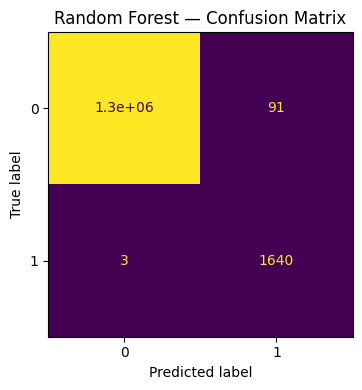

XGBoost — Classification report

              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9998   1270881
           1     0.7399    0.9988    0.8500      1643

    accuracy                         0.9995   1272524
   macro avg     0.8699    0.9992    0.9249   1272524
weighted avg     0.9997    0.9995    0.9996   1272524



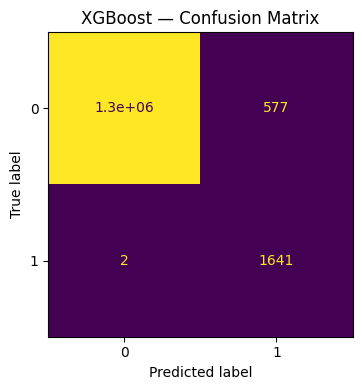

In [16]:

def show_report_and_cm(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    print(f"{title} — Classification report\n")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{title} — Confusion Matrix")
    plt.tight_layout(); plt.show()

show_report_and_cm(rf,  X_test, y_test, "Random Forest")
show_report_and_cm(xgb, X_test, y_test, "XGBoost")


## ROC & Precision–Recall curves (+ PR-AUC — crucial for imbalance)

Random Forest — ROC-AUC: 0.999830 | PR-AUC (Average Precision): 0.998711


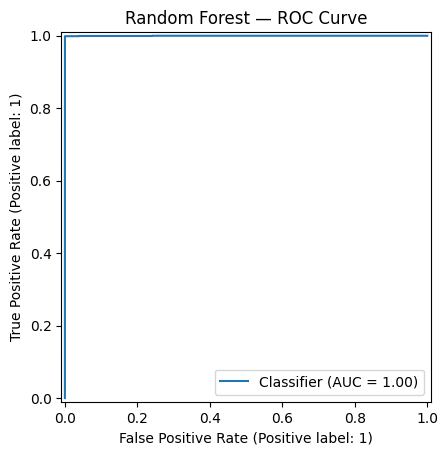

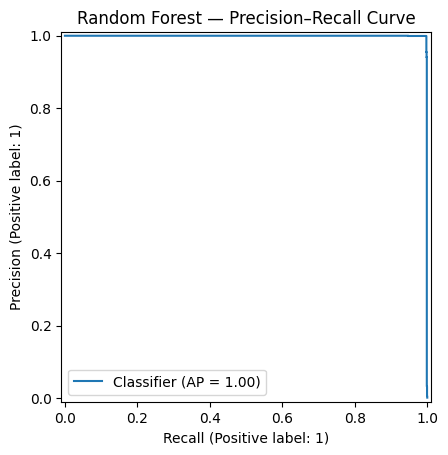

XGBoost — ROC-AUC: 0.999372 | PR-AUC (Average Precision): 0.965727


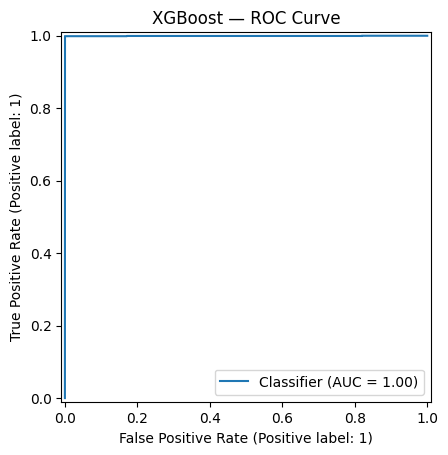

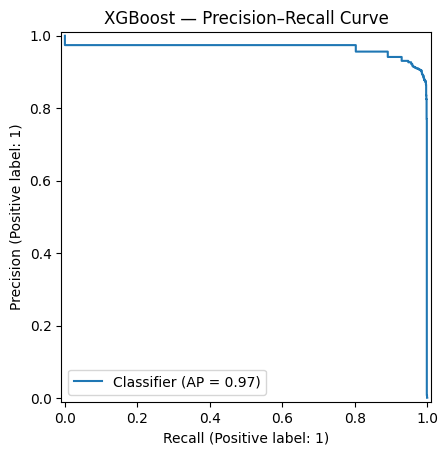

In [17]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, roc_auc_score

def curves(model, X_test, y_test, title):
    y_proba = model.predict_proba(X_test)[:,1]
    ap = average_precision_score(y_test, y_proba)
    roc = roc_auc_score(y_test, y_proba)
    print(f"{title} — ROC-AUC: {roc:.6f} | PR-AUC (Average Precision): {ap:.6f}")

    # ROC
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{title} — ROC Curve")
    plt.show()

    # PR
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{title} — Precision–Recall Curve")
    plt.show()

curves(rf,  X_test, y_test, "Random Forest")
curves(xgb, X_test, y_test, "XGBoost")
